# Main

In [460]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import seaborn as sns

In [461]:
# processed db includes datetime and data is converted to numeric
db_file_path = "../data/can_data_processed_23112023.db"
conn = sqlite3.connect(db_file_path)

In [462]:
# plot consistency
sns.set_style("whitegrid")
sns.set_palette("pastel")
pd.set_option("float_format", "{:f}".format)
common_figsize = (14, 8)

In [463]:
# read data
query = "SELECT * FROM ProcessedCANData"
df = pd.read_sql_query(query, conn)
conn.close()

In [464]:
df.columns

Index(['DrBack_Press', 'Supply_Press', 'Oil_Temp', 'Cool_Temp',
       'Steering_Angle', 'Amb_Temp', 'FuelPressure', 'Cab_Angle', 'Drive_Dir',
       'timestamp', 'WorkPump_Press', 'file', 'ChargedAir_Press',
       'RetFilt_Press', 'CraneSwivel_Angle', 'HeadPump_Angle', 'DrFor_Press',
       'Engine_Load', 'Bat_Volt', 'Oil_Press', 'Speed', 'FrameFB_Angle',
       'FrameLR_Angle', 'RPM_DriveMot', 'WorkPump_Q', 'RPM_Diesel',
       'datetime'],
      dtype='object')

In [465]:
data = df[["FuelPressure", "Engine_Load", "RPM_Diesel"]]  # , 'datetime', 'timestamp']]

# Descriptive Statistics

In [466]:
descriptive_stats = data.describe()
skewness = data.skew().rename("skewness")
kurtosis = data.kurtosis().rename("kurtosis")

all_stats = pd.concat([descriptive_stats.T, skewness, kurtosis], axis=1)

In [467]:
all_stats.T

,FuelPressure,Engine_Load,RPM_Diesel
count,2238512.000000,2238512.000000,2230676.000000
mean,2.162718,10.664446,484.030519
std,2.287662,12.251977,556.114354
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,4.400000,21.000000,800.000000
max,5.160000,125.000000,1838.000000
skewness,0.123955,0.815612,0.614845
kurtosis,-1.961738,0.610495,-1.016291


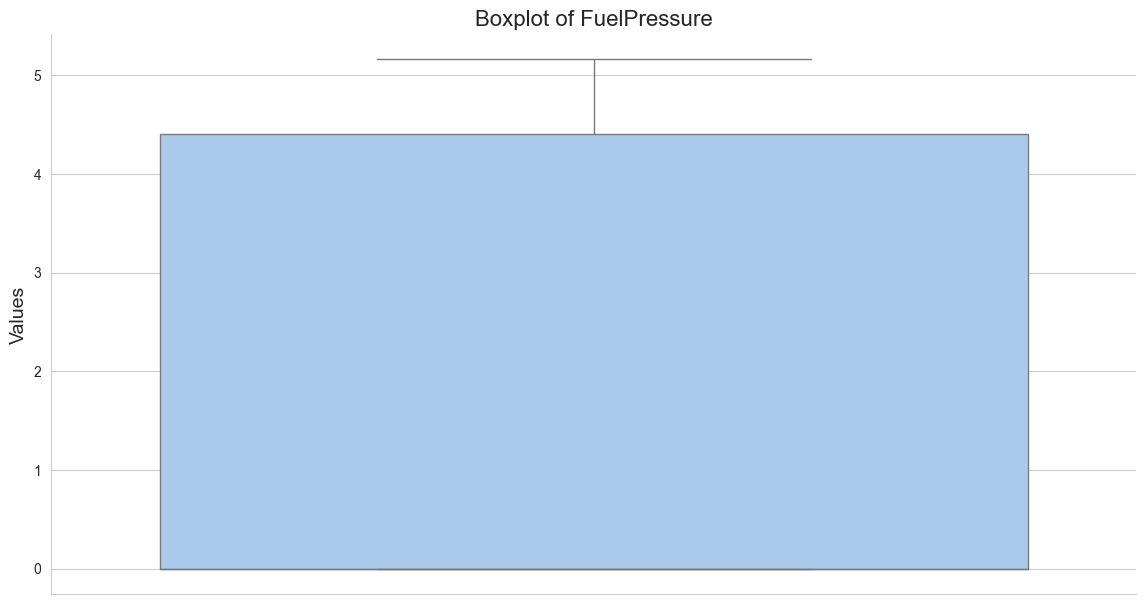

In [468]:
plt.figure(figsize=common_figsize)
sns.boxplot(data=data["FuelPressure"])
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.ylabel("Values", fontsize=14)
plt.title("Boxplot of FuelPressure", fontsize=16)
plt.subplots_adjust(bottom=0.2, top=0.9)
sns.despine()
plt.show()

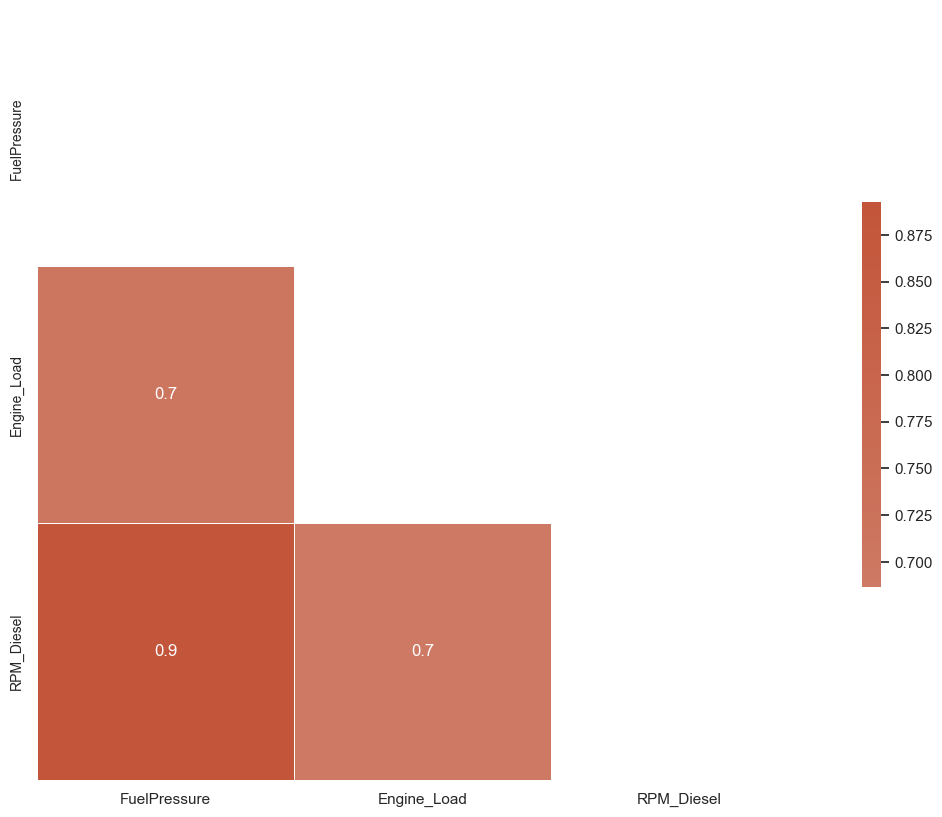

In [469]:
correlation_matrix = data.corr(method="kendall")
plt.figure(figsize=(14, 10))
sns.set(style="white")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    fmt=".1f",
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
# plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

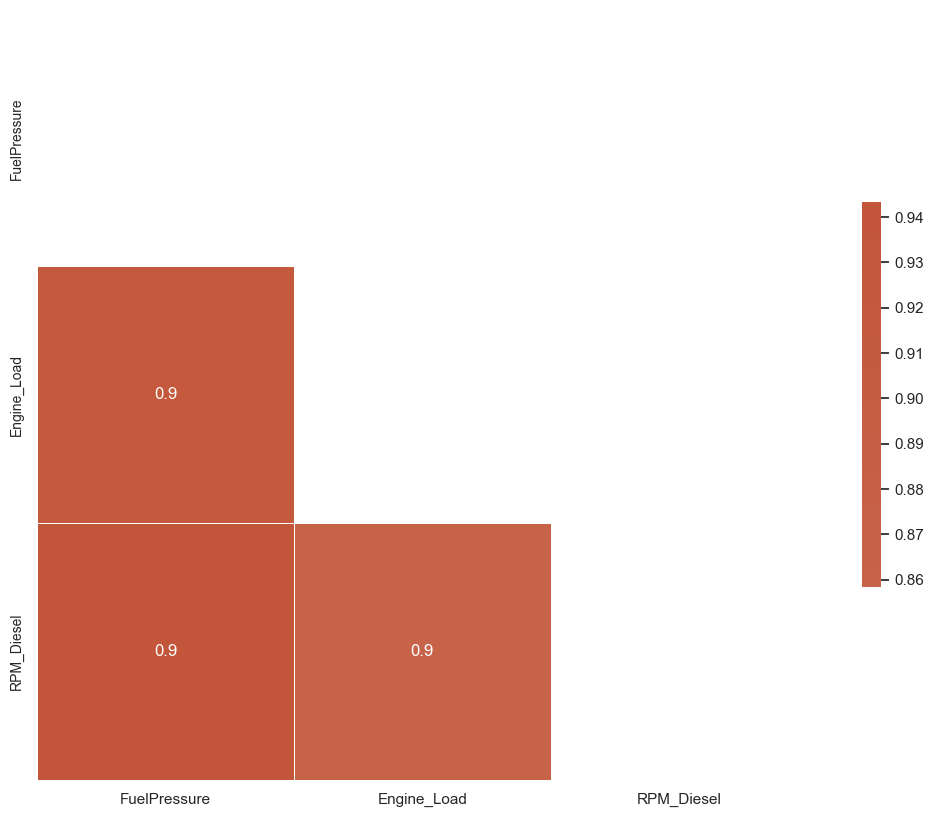

In [470]:
correlation_matrix = data.corr(method="pearson")
plt.figure(figsize=(14, 10))
sns.set(style="white")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    fmt=".1f",
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
# plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [471]:
print(pd.unique(df["FuelPressure"]))
print(len(pd.unique(df["FuelPressure"])))

[0.    nan 5.   4.96 5.04 4.88 4.68 4.52 4.44 4.48 4.6  4.76 4.72 4.8
 4.84 4.64 4.92 5.12 5.16 5.08 4.32 3.88 2.2  1.04 0.56 0.36 0.28 0.2
 0.16 0.12 0.08 0.04 2.68 4.04 4.4  4.36 4.56 4.08 2.64 1.24 0.6  0.24
 0.48 2.52 4.24 3.96 0.92 0.44 2.12 3.84 4.28 1.76 0.64 0.32 2.76 4.
 0.72 3.08 4.12 4.2  2.28 0.4 ]
62


# Data Distribution

In [472]:
def freedman_diaconis_bins(data):
    data = data.astype(float)
    if len(data) > 1 and data.nunique() > 1:
        quartile_range = np.percentile(data, 75) - np.percentile(data, 25)
        if quartile_range == 0:
            return 1
        bin_width = 2 * quartile_range * (len(data) ** (-1 / 3))
        num_bins = (data.max() - data.min()) / bin_width
        return max(1, round(num_bins))
    else:
        return 1


def remove_outliers(df, column, multiplier=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:  # Handle case where all data points are the same
        return df
    lower_bound = q1 - (multiplier * iqr)
    upper_bound = q3 + (multiplier * iqr)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

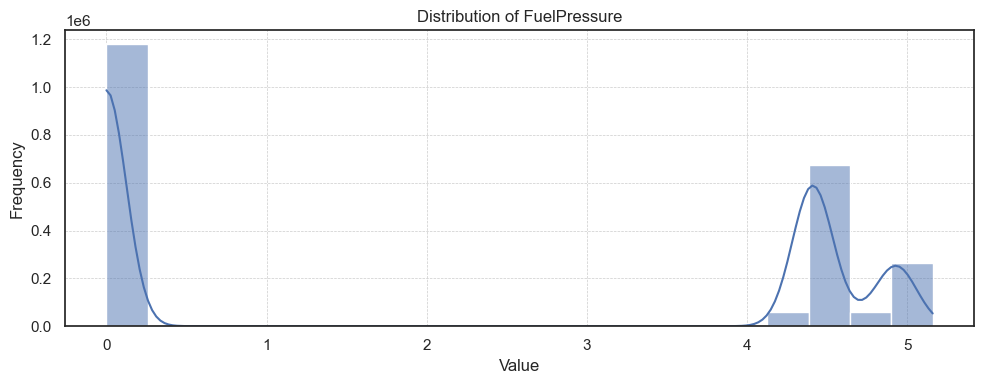

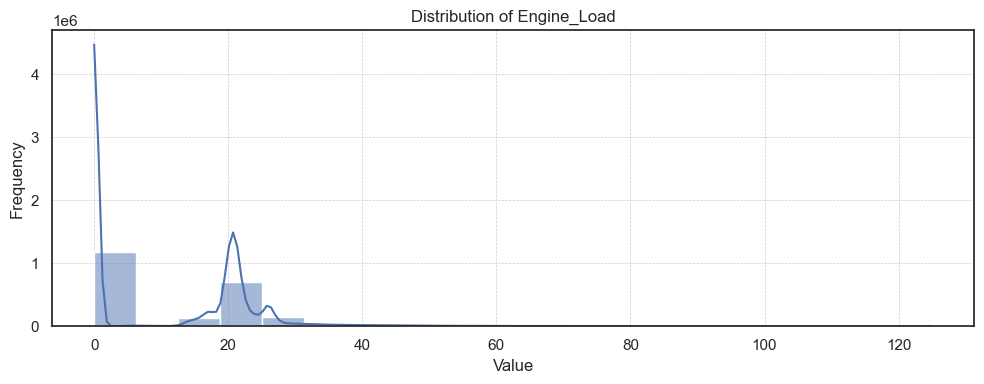

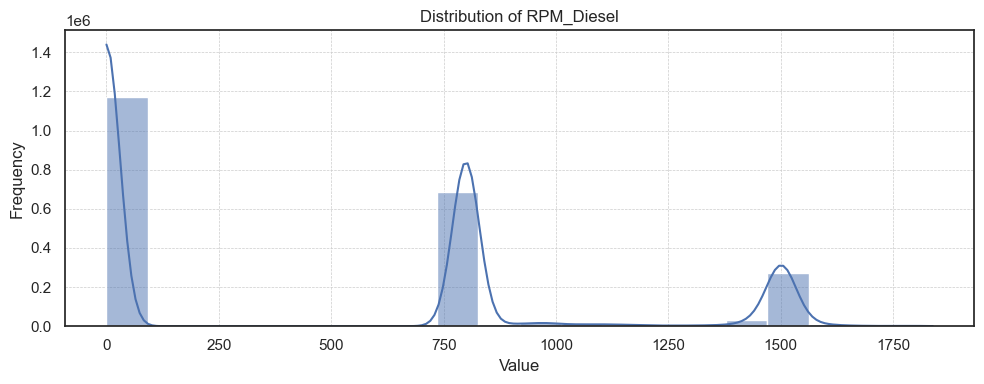

In [473]:
for column in data.columns:
    if data[column].isna().all():
        continue

    column_data = data[column].dropna()
    bins = freedman_diaconis_bins(column_data) if len(column_data) > 1 else 1

    plt.figure(figsize=(10, 4))
    plt.hist(column_data, bins=bins, edgecolor="black", alpha=0.7, density=True)
    sns.histplot(column_data, bins=20, kde=True)

    plt.title(f"Distribution of {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [474]:
df_clean = data.copy()

for column in data.columns:
    if data[column].dtype in ["float64", "int64"] and data[column].nunique() > 1:
        df_clean = remove_outliers(df_clean, column)

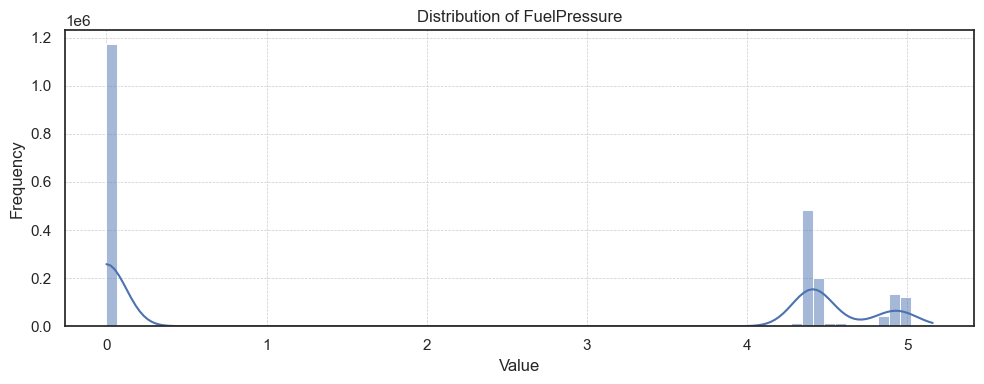

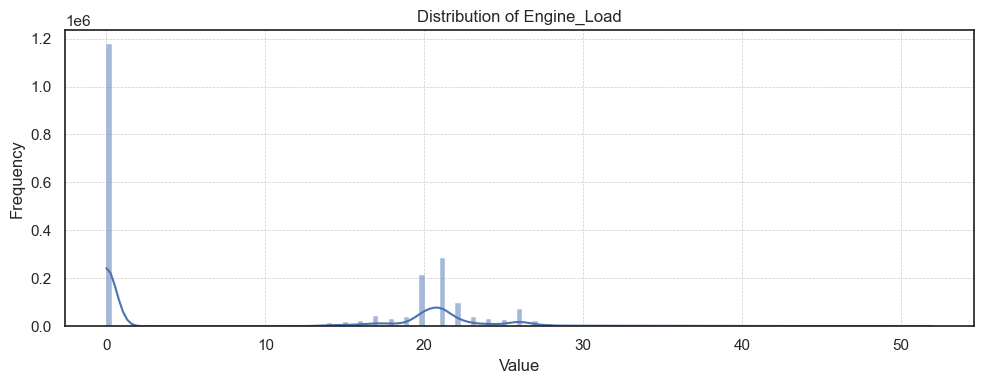

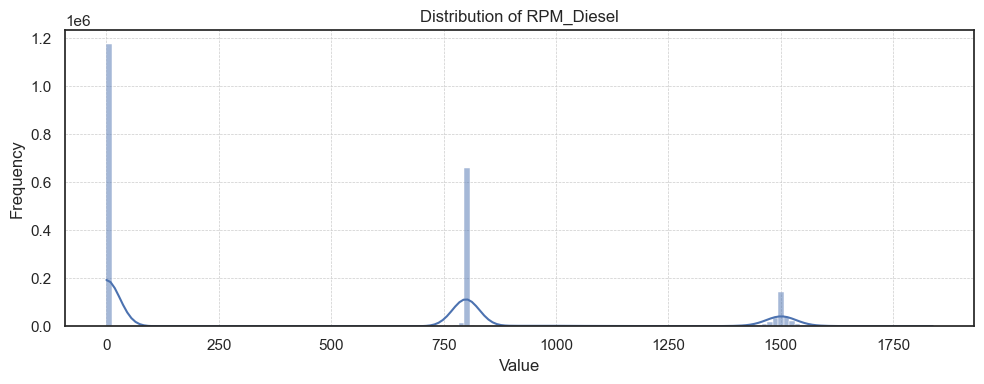

In [475]:
for column in df_clean.columns:
    if df_clean[column].isna().all() or df_clean[column].nunique() == 1:
        continue
    try:
        column_data = pd.to_numeric(df_clean[column].dropna(), errors="coerce")
        bins = freedman_diaconis_bins(column_data) if len(column_data) > 1 else 1
    except ValueError:
        continue

    plt.figure(figsize=(10, 4))
    plt.hist(column_data, bins=bins, edgecolor="black", alpha=0.7, density=True)

    if column_data.nunique() != 1:
        sns.histplot(column_data, bins=bins, kde=True)

    plt.title(f"Distribution of {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()

    plt.show()

In [476]:
sns.scatterplot(x="FuelPressure", y="RPM_Diesel", data=df, color="blue")

<Axes: xlabel='FuelPressure', ylabel='RPM_Diesel'>

Error in callback <function flush_figures at 0x00000139CFE874C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

<Axes: xlabel='FuelPressure', ylabel='Engine_Load'>

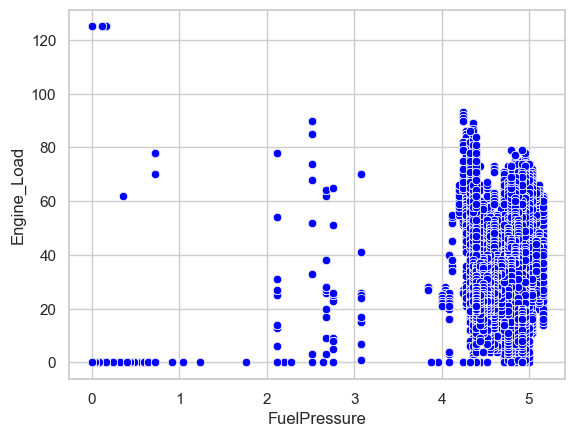

In [ ]:
sns.scatterplot(x="FuelPressure", y="Engine_Load", data=df, color="blue")

# External Data Analysis

## Main 

In [ ]:
df_ext = pd.read_csv("../data/external_data/engine_data.csv", index_col=None)
df_ext = df_ext.rename(
    columns={"Fuel pressure": "FuelPressure", "Engine rpm": "RPM_Diesel"}
)
df_ext.head()

,RPM_Diesel,Lub oil pressure,FuelPressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


## External Data Descriptive Statistics

In [ ]:
descriptive_stats_ext = df_ext.describe()
skewness_ext = df_ext.skew().rename("skewness")
kurtosis_ext = df_ext.kurtosis().rename("kurtosis")

all_stats_ext = pd.concat([descriptive_stats_ext.T, skewness_ext, kurtosis_ext], axis=1)

<Axes: >

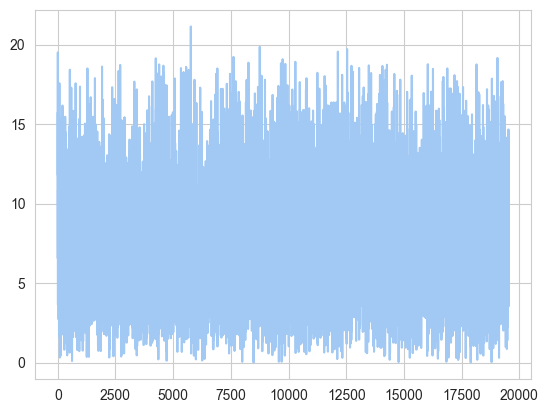

In [ ]:
df_ext["FuelPressure"].plot()

In [ ]:
all_stats_ext.T

,RPM_Diesel,Lub oil pressure,FuelPressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433,0.630509
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749,0.482679
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325,0.000000
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421,0.000000
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662,1.000000
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411,1.000000
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912,1.000000
skewness,0.934932,0.195783,1.216387,1.309420,1.496375,0.404451,-0.540826
kurtosis,0.936921,-0.260152,2.452666,2.556044,1.749363,5.880549,-1.707682


In [ ]:
correlation_matrix_ext_kendall = df_ext[["FuelPressure", "RPM_Diesel"]].corr(
    method="kendall"
)
correlation_matrix_ext_spearman = df_ext[["FuelPressure", "RPM_Diesel"]].corr(
    method="spearman"
)
correlation_matrix_ext_pearson = df_ext[["FuelPressure", "RPM_Diesel"]].corr(
    method="pearson"
)

In [ ]:
correlation_matrix_ext_pearson

,FuelPressure,RPM_Diesel
FuelPressure,1.000000,-0.001571
RPM_Diesel,-0.001571,1.000000


In [ ]:
correlation_matrix_ext_kendall

,FuelPressure,RPM_Diesel
FuelPressure,1.000000,-0.004791
RPM_Diesel,-0.004791,1.000000


In [ ]:
correlation_matrix_ext_spearman

,FuelPressure,RPM_Diesel
FuelPressure,1.000000,-0.007113
RPM_Diesel,-0.007113,1.000000


In [ ]:
print(pd.unique(df_ext["FuelPressure"]))
print(len(pd.unique(df_ext["FuelPressure"])))

[11.79092738 16.19386556  6.55314691 ...  4.92737579  8.29181555
  3.96248044]
19531


## External Data Distribution

In [ ]:
from scipy.stats import norm, expon

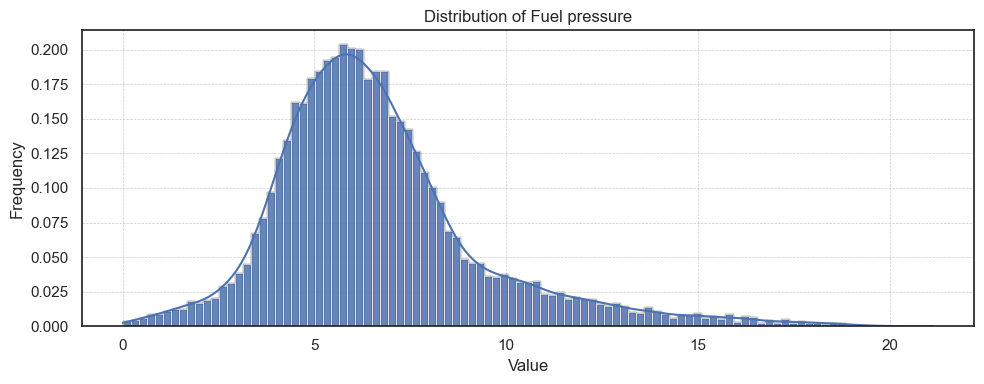

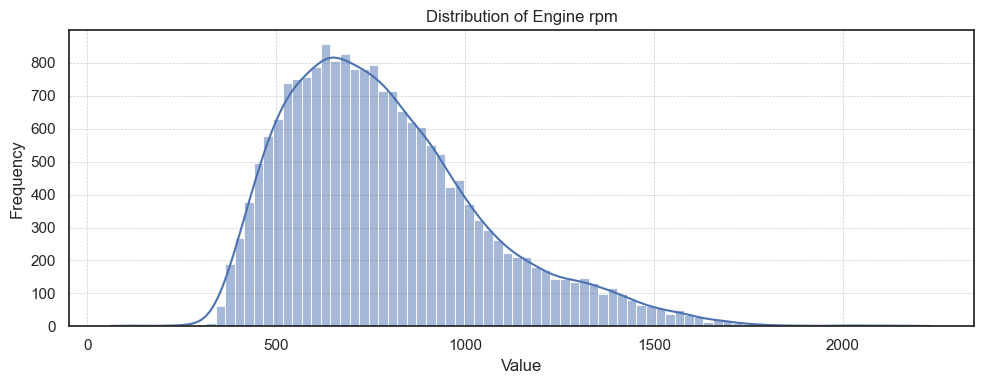

In [ ]:
bins = freedman_diaconis_bins(df_ext["FuelPressure"])

plt.figure(figsize=(10, 4))
plt.hist(df_ext["FuelPressure"], bins=bins, edgecolor="black", alpha=0.7, density=True)
sns.histplot(df_ext["FuelPressure"], stat="density", bins=bins, kde=True)

plt.title("Distribution of Fuel pressure")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

bins = freedman_diaconis_bins(df_ext["RPM_Diesel"])

plt.figure(figsize=(10, 4))
plt.hist(df_ext["RPM_Diesel"], bins=bins, edgecolor="black", alpha=0.7, density=True)
sns.histplot(df_ext["RPM_Diesel"], bins=bins, kde=True)

plt.title("Distribution of Engine rpm")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
df_ext_cleaned = df_ext[["RPM_Diesel", "FuelPressure"]].copy()

for column in df_ext_cleaned.columns:
    if (
        df_ext_cleaned[column].dtype in ["float64", "int64"]
        and df_ext_cleaned[column].nunique() > 1
    ):
        df_ext_cleaned = remove_outliers(df_ext_cleaned, column)

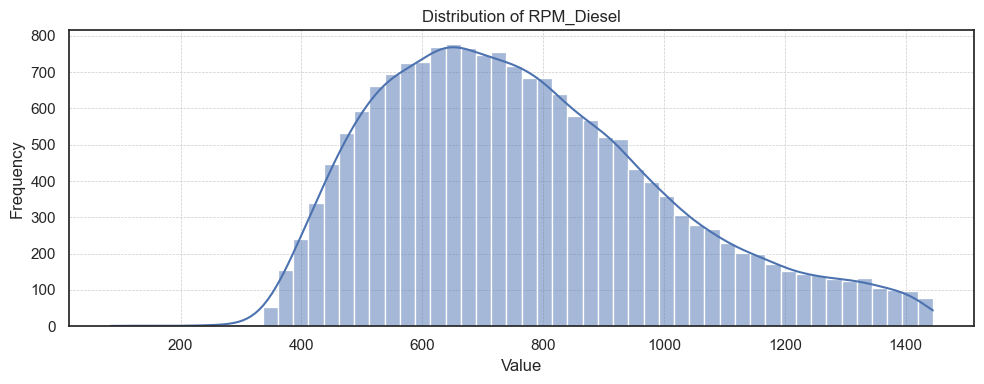

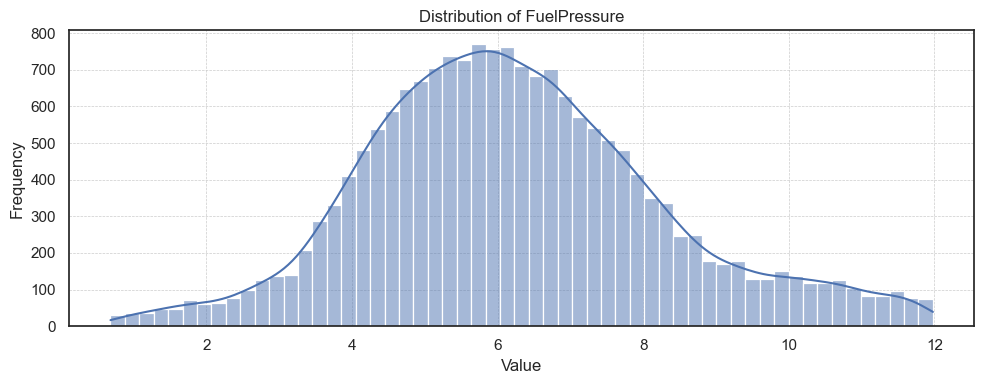

In [ ]:
for column in df_ext_cleaned.columns:
    if df_ext_cleaned[column].isna().all() or df_ext_cleaned[column].nunique() == 1:
        continue
    try:
        column_data = pd.to_numeric(df_ext_cleaned[column].dropna(), errors="coerce")
        bins = freedman_diaconis_bins(column_data) if len(column_data) > 1 else 1
    except ValueError:
        continue

    plt.figure(figsize=(10, 4))
    plt.hist(column_data, bins=bins, edgecolor="black", alpha=0.7, density=True)

    if column_data.nunique() != 1:
        sns.histplot(column_data, bins=bins, kde=True)

    plt.title(f"Distribution of {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()

    plt.show()

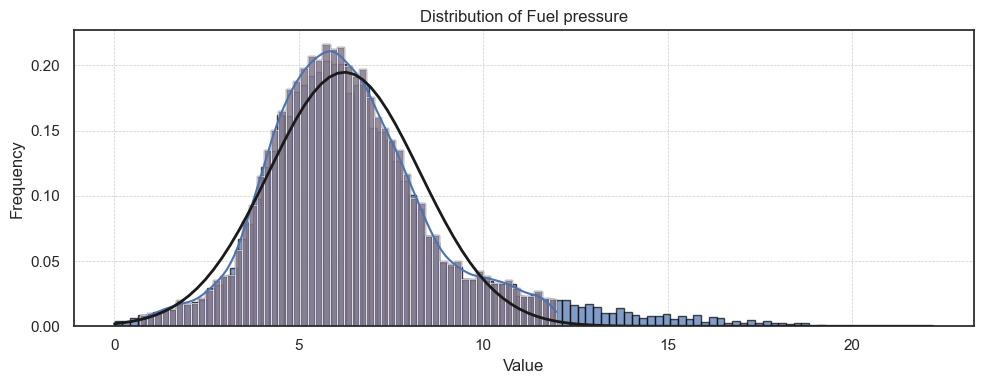

In [ ]:
data_to_plot = df_ext_cleaned["FuelPressure"]
plt.figure(figsize=(10, 4))

# data
bins = freedman_diaconis_bins(df_ext["FuelPressure"])
plt.hist(df_ext["FuelPressure"], bins=bins, edgecolor="black", alpha=0.7, density=True)
# sns.histplot(df_ext["FuelPressure"], stat='density', bins=bins, kde=True)

# cleaned data
bins_clean = freedman_diaconis_bins(data_to_plot)
plt.hist(data_to_plot, bins=bins_clean, edgecolor="black", alpha=0.7, density=True)
sns.histplot(data_to_plot, stat="density", bins=bins_clean, kde=True)

# normal distribution
mu, std = norm.fit(data_to_plot)
# mu = mu - 0.4
# std = std - 0.1
xmin, xmax = plt.xlim()
x = np.linspace(0, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2)

plt.title("Distribution of Fuel pressure")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

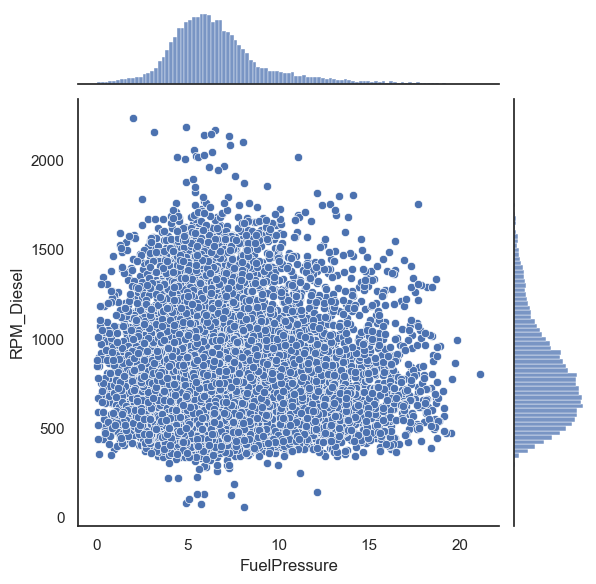

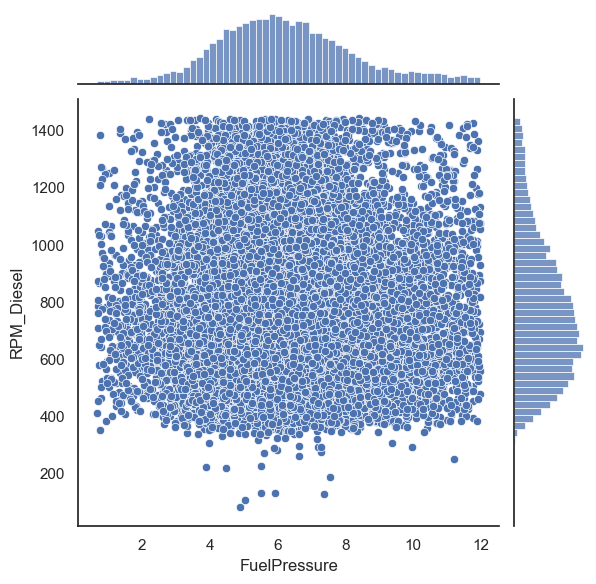

In [ ]:
sns.jointplot(df_ext, x="FuelPressure", y="RPM_Diesel")
sns.jointplot(df_ext_cleaned, x="FuelPressure", y="RPM_Diesel")

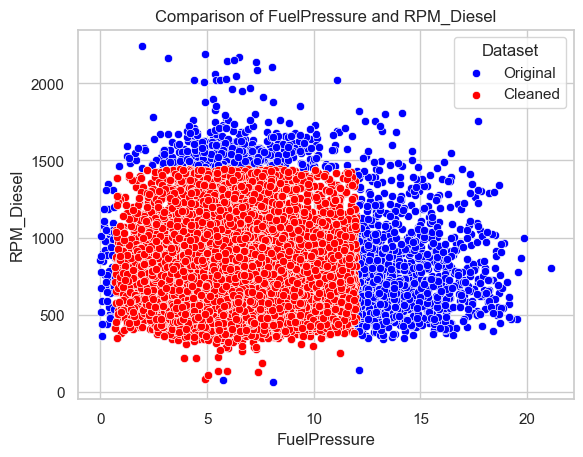

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, ax = plt.subplots()

sns.scatterplot(
    x="FuelPressure", y="RPM_Diesel", data=df_ext, ax=ax, color="blue", label="Original"
)

sns.scatterplot(
    x="FuelPressure",
    y="RPM_Diesel",
    data=df_ext_cleaned,
    ax=ax,
    color="red",
    label="Cleaned",
)

ax.legend(title="Dataset")
ax.set_xlabel("FuelPressure")
ax.set_ylabel("RPM_Diesel")
ax.set_title("Comparison of FuelPressure and RPM_Diesel")

plt.show()

# Concatenated Data Distribution

In [ ]:
df_int = pd.concat(
    [df_ext[["FuelPressure", "RPM_Diesel"]], df[["FuelPressure", "RPM_Diesel"]]], axis=0
)

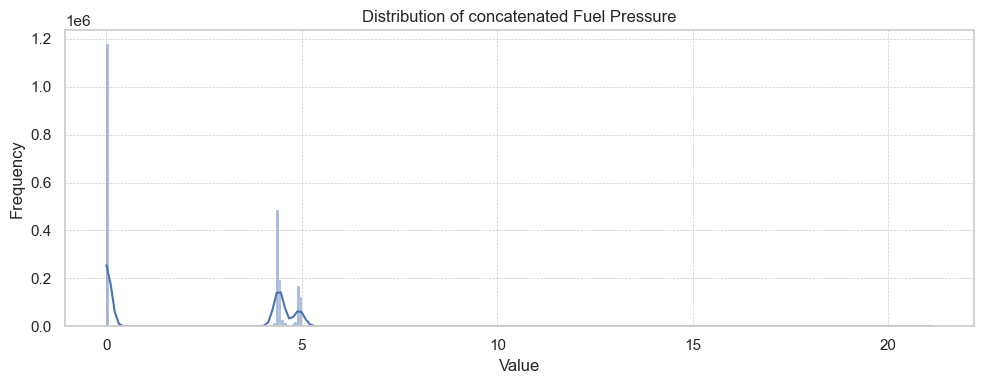

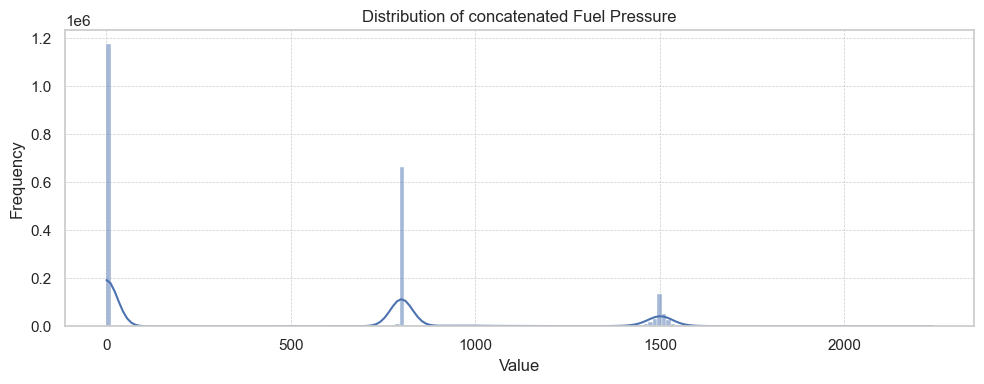

In [ ]:
for column in df_int.columns:
    data_to_plot = df_int[column].dropna()
    bins = freedman_diaconis_bins(data_to_plot)

    plt.figure(figsize=(10, 4))
    plt.hist(data_to_plot, bins=bins, edgecolor="black", alpha=0.7, density=True)
    sns.histplot(data_to_plot, bins=bins, kde=True)

    plt.title("Distribution of concatenated Fuel Pressure")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
df_ext_upsampled = df_ext.copy()

while len(df_ext_upsampled) < len(df):
    df_ext_upsampled = pd.concat([df_ext_upsampled, df_ext], ignore_index=True)

df_concatenated = pd.concat([df_ext_upsampled, df], axis=0).reset_index(drop=True)

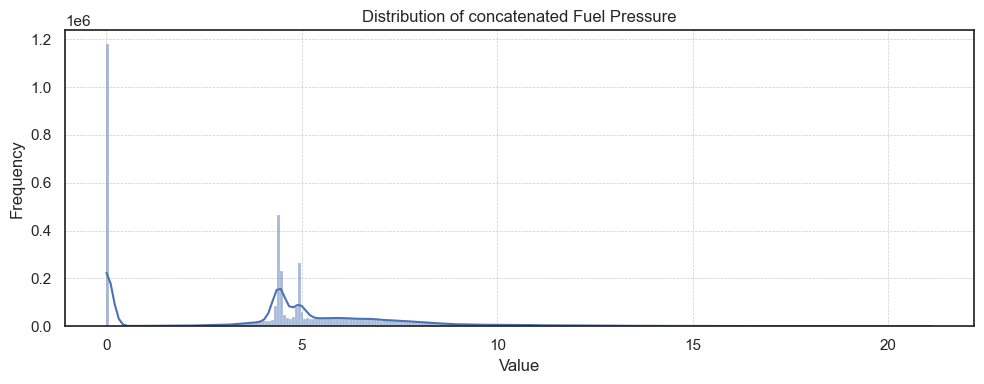

In [ ]:
data_to_plot = df_concatenated["FuelPressure"].dropna()
bins = freedman_diaconis_bins(data_to_plot)

plt.figure(figsize=(10, 4))
plt.hist(data_to_plot, bins=bins, edgecolor="black", alpha=0.7, density=True)
sns.histplot(data_to_plot, bins=bins, kde=True)

plt.title("Distribution of concatenated Fuel Pressure")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
print(pd.unique(df_ext["FuelPressure"]))
print(pd.unique(df["FuelPressure"]))

[11.79092738 16.19386556  6.55314691 ...  4.92737579  8.29181555
  3.96248044]
[0.    nan 5.   4.96 5.04 4.88 4.68 4.52 4.44 4.48 4.6  4.76 4.72 4.8
 4.84 4.64 4.92 5.12 5.16 5.08 4.32 3.88 2.2  1.04 0.56 0.36 0.28 0.2
 0.16 0.12 0.08 0.04 2.68 4.04 4.4  4.36 4.56 4.08 2.64 1.24 0.6  0.24
 0.48 2.52 4.24 3.96 0.92 0.44 2.12 3.84 4.28 1.76 0.64 0.32 2.76 4.
 0.72 3.08 4.12 4.2  2.28 0.4 ]


In [ ]:
np.sum(
    [
        element in pd.unique(df_ext["FuelPressure"])
        for element in pd.unique(df["FuelPressure"])
    ]
)

0

# Final Data 

## Data Concatetion

In [ ]:
diesel_filter_data = pd.Series(np.concatenate((df_ext["FuelPressure"], pd.unique(df["FuelPressure"].dropna()))))

## Data Fitting

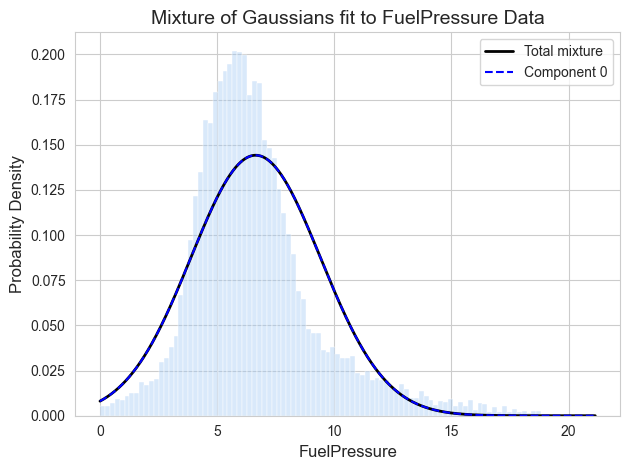

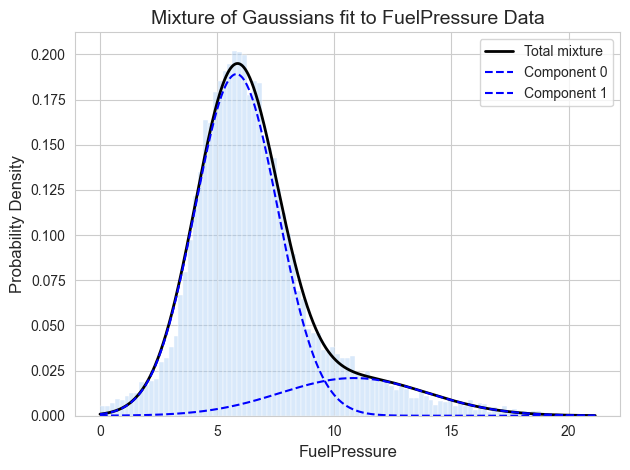

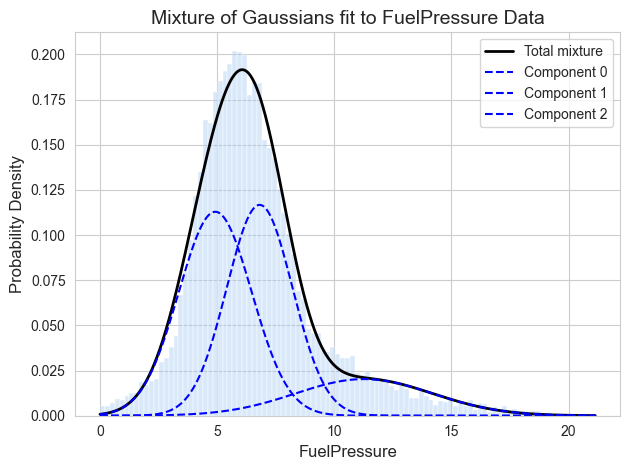

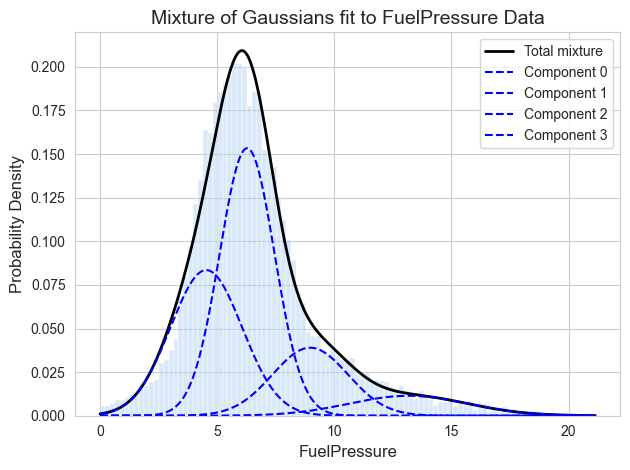

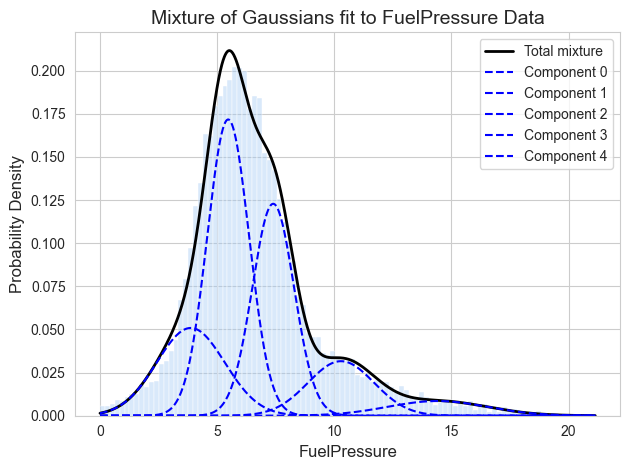

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy import stats

gmm = {}

for k in gmm.keys():
    data = diesel_filter_data.values.reshape(-1, 1)
    gmm[k] = GaussianMixture(n_components=k, random_state=40)
    gmm[k].fit(data)
    x = np.linspace(data.min(), data.max(), 2000).reshape(-1, 1)
    pdf_individual = [
        gmm[k].weights_[i]
        * stats.norm(gmm[k].means_[i, 0], np.sqrt(gmm[k].covariances_[i, 0])).pdf(x).flatten()
        for i in range(gmm[k].n_components)
    ]
    pdf_total = np.sum(pdf_individual, axis=0)

    sns.histplot(
        data,
        bins=freedman_diaconis_bins(diesel_filter_data),
        kde=False,
        stat="density",
        color="grey",
        alpha=0.4,
    )
    plt.plot(x, pdf_total, color="black", lw=2, label="Total mixture")

    for l in range(gmm[k].n_components):
        plt.plot(x, pdf_individual[l], "--", color='blue', lw=1.5, label=f"Component {l+1}")
        # plt.plot(x, pdf_individual[1], "--", color='blue', lw=1.5, label=f"Normal Behavior")
        # plt.plot(x, pdf_individual[2], "--", color='green', lw=1.5, label=f"Drift Behavior")
        # plt.plot(x, pdf_individual[3], "--", color='red', lw=1.5, label=f"Faulty Behavior")

    plt.xlabel("FuelPressure", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.title("Mixture of Gaussians fit to FuelPressure Data", fontsize=14)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

### Analysis
- k=1, underfitting, k=5 overfitting
- k=2, 3, 4 require further analysis

In [ ]:
weights_list = []
means_list = []
covariances_list = []
components_list = []

for k, gmm_model in gmm.items():
    weights_list.append(gmm_model.weights_.flatten())
    means_list.append(gmm_model.means_.flatten())
    covariances_list.append(gmm_model.covariances_.flatten())
    components_list.append(gmm_model.n_components)

df_parameters = pd.DataFrame({
    'GMM_Key': gmm.keys(),
    'Weights': weights_list,
    'Means': means_list,
    'Covariances': covariances_list,
    'Num_Components': components_list
})


In [ ]:
df_parameters.set_index("Num_Components", inplace=True)

# Zero Values 

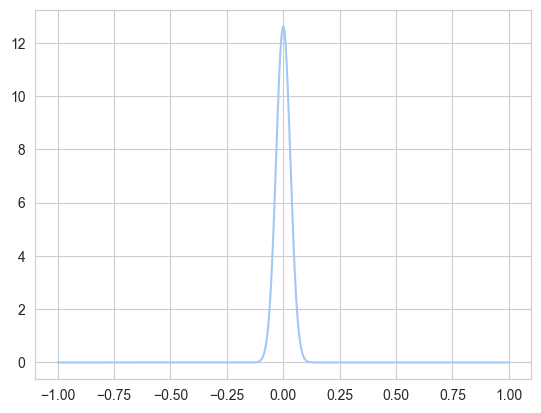

In [ ]:
mean = 0
variance = 0.001
pdf_zero = 0.1 * stats.norm(mean, np.sqrt(variance)).pdf(x).flatten()
plt.plot(x, stats.norm(mean, np.sqrt(variance)).pdf(x).flatten())
plt.show()

## Autocorrelation

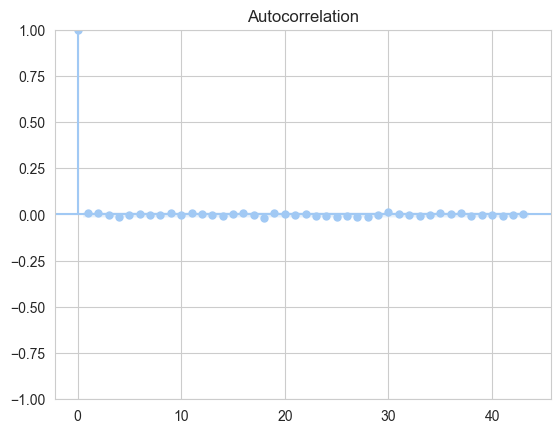

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diesel_filter_data, alpha=0.05)
plt.show()

c:\Python311\Lib\site-packages\arch\univariate\base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
c:\Python311\Lib\site-packages\arch\univariate\base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
c:\Python311\Lib\site-packages\arch\univariate\base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  converted = format_flo

                     Constant Mean - GARCH Model Results                      
Dep. Variable:           FuelPressure   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -47547.2
Distribution:                  Normal   AIC:                           95102.4
Method:            Maximum Likelihood   BIC:                           95134.0
                                        No. Observations:                19535
Date:                Tue, Dec 12 2023   Df Residuals:                    19534
Time:                        12:24:49   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             6.6542  1.975e-02    336.968      0.000 [  6.615,  6.69

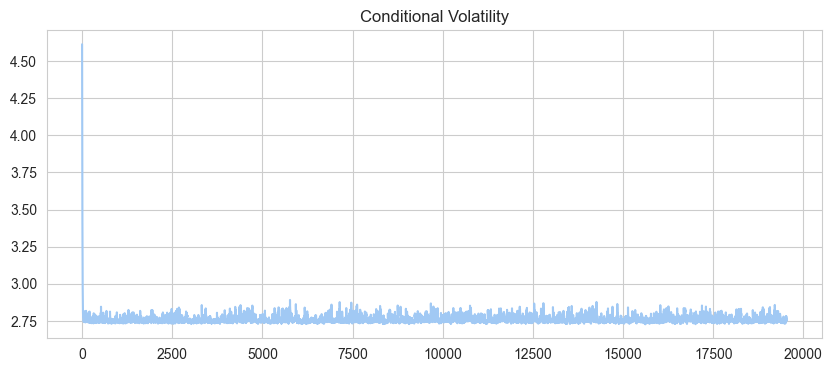

In [ ]:
import numpy as np
from arch import arch_model

model = arch_model(diesel_filter_data, vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

print(model_fit.summary())

conditional_volatility = model_fit.conditional_volatility

plt.figure(figsize=(10, 4))
plt.plot(conditional_volatility)
plt.title('Conditional Volatility')
plt.show()


# Data Sampling

## Ancestral Sampling for GMM

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

# ancestral sampling
def sample_from_gmm(gmm, n_samples=1):
    components = np.random.choice(len(gmm.weights_), size=n_samples, p=gmm.weights_)
    samples = np.array(
        [
            np.random.multivariate_normal(
                mean=gmm.means_[component], cov=gmm.covariances_[component], size=1
            ).flatten()
            for component in components
        ]
    )
    
    return samples.flatten()

[0 0 0 ... 0 0 0]
[[5.06866168]
 [8.73632281]
 [4.97678634]
 ...
 [5.17812772]
 [6.3767561 ]
 [4.83624885]]


<Axes: ylabel='Density'>

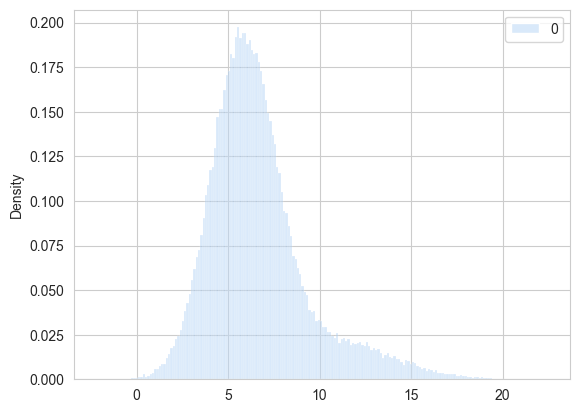

In [ ]:
data = sample_from_gmm(gmm[k], n_samples=100000)
sns.histplot(
    data,
    bins=freedman_diaconis_bins(pd.Series(data.flatten())),
    kde=False,
    stat="density",
    color="grey",
    alpha=0.4,
)

## Box Muller Algorithm

In [ ]:
def box_muller(n):
    u1 = np.random.uniform(size=n)
    u2 = np.random.uniform(size=n)
    r = np.sqrt(-2 * np.log(u1))
    theta = 2 * np.pi * u2
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

n = 100000
samples_z0, samples_z1 = box_muller(n)

transformed_samples_z0 = (gmm[k].covariances_[0] * samples_z0 + gmm[k].means_[0]).flatten()
transformed_samples_z1 = (gmm[k].covariances_[1] * samples_z1 + gmm[k].means_[1]).flatten()

drawn_samples_z0 = np.random.choice(transformed_samples_z0, size=int(n*gmm[k].weights_[0]), replace=False)
drawn_samples_z1 = np.random.choice(transformed_samples_z1, size=int(n*gmm[k].weights_[1]), replace=False)

full_samples = np.concatenate((drawn_samples_z0, drawn_samples_z1)) 


## Sampling Inactive Data

### 
- Fuel pressure is 0, when:
    1. sensor is faulty (not reading)
    2. no pressure, due inactivity

In [ ]:
def sample_zero_sensor_reading(n_samples=1):
    mean = np.array([0])
    variance = np.array([[0.001]])
    samples = []
    for i in range(n_samples):
        sample = np.random.multivariate_normal(
                mean=mean, cov=variance, size=1
            ).flatten() 
        samples.append(sample)
    samples = np.array(samples)
    return samples[samples>=0].flatten()


## Sampling Process

In [ ]:
def sample_data(gmm, n_samples=1, zero_weight=0.02):
    sampling_scenarios_weights = np.array([zero_weight, 1-zero_weight])
    components = np.random.choice(len(sampling_scenarios_weights), size=n_samples, p=sampling_scenarios_weights) # array of 0 or 1
    samples = []
    for component in components:
        if component == 1:
            sample = sample_from_gmm(gmm, 1)  # Assuming sample_from_gmm can handle single-sample generation
        else:
            sample = sample_zero_sensor_reading(1)
        samples.append(sample)
    return np.array(samples)
   

# Plausibility Check

In [ ]:
data = diesel_filter_data.values.reshape(-1, 1).flatten()
df_stats = pd.DataFrame()
for k in gmm.keys():
    print(f"{k}")
    samples = sample_from_gmm(gmm[k], n_samples=10*len(data))
    ks_statistic, p_value = stats.ks_2samp(data, samples)
    result = stats.cramervonmises_2samp(data, samples)
    cvm_statistic = result.statistic
    cvm_p_value = result.pvalue
    ad_statistic, ad_critical_values, ad_significance_level = stats.anderson_ksamp([data, samples])
    # print(f"P Value for GMM with {k} components:", p_value, result.pvalue, ad_significance_level)
    row_data = pd.DataFrame({"number of components": [k], "ks_2samp": [p_value], "cramervonmises_2samp": [result.pvalue], "anderson_ksamp": [ad_significance_level]})
    df_stats = pd.concat([df_stats, row_data], ignore_index=True)
df_stats.set_index("number of components", inplace=True)

1


C:\Users\U\AppData\Local\Temp\ipykernel_13960\3431542339.py:10: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic, ad_critical_values, ad_significance_level = stats.anderson_ksamp([data, samples])


2
3
4
5


In [ ]:
df_stats

,ks_2samp,cramervonmises_2samp,anderson_ksamp
number of components,,,
1,0.000000,0.000000,0.001000
2,0.000623,0.019010,0.001000
3,0.000007,0.001414,0.001000
4,0.002643,0.010026,0.001032
5,0.104402,0.170490,0.062803


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot_2samples

for k in gmm.keys():
    samples = sample_from_gmm(gmm[k], n_samples=2*len(data))

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.hist(diesel_filter_data, bins=50, density=True, alpha=0.5, label='Original Data')
    plt.title('Histogram of Original Data')
    plt.xlabel('Data')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(samples, bins=50, density=True, alpha=0.5, label='Sampled Data', color='orange')
    plt.title('Histogram of Sampled Data')
    plt.xlabel('Data')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

    stats.probplot(samples, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.show()

    qqplot_2samples(diesel_filter_data, samples, line='45')
    plt.title('P-P Plot')
    plt.show()


KeyboardInterrupt: 

In [ ]:
from scipy.stats import chi2

for k in gmm.keys():
    log_likelihoods_null = gmm[k].score_samples(data.reshape(-1, 1))
    log_likelihood_null_model = np.sum(log_likelihoods_null)

    log_likelihoods_alternative = gmm[5].score_samples(data.reshape(-1, 1))
    log_likelihood_alternative_model = np.sum(log_likelihoods_alternative) 

    test_statistic = -2 * (log_likelihood_null_model - log_likelihood_alternative_model)
    # 3k-1 for k-gmm
    degrees_of_freedom = 14 - (3*k-1)

    p_value = chi2.sf(test_statistic, degrees_of_freedom)

    print(f"{k}. Test Statistic: {test_statistic}. p-value: {p_value}")
    


1. Test Statistic: 4555.59622306739. p-value: 0.0
2. Test Statistic: 135.6096941799915. p-value: 8.301536266574594e-25
3. Test Statistic: 253.1140882121108. p-value: 8.858897715850653e-52
4. Test Statistic: 125.42684487054066. p-value: 5.229546744973682e-27
5. Test Statistic: -0.0. p-value: nan


# Final Data Model

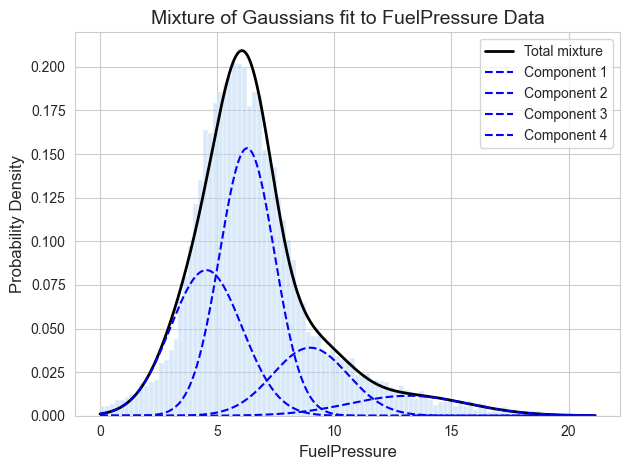

In [ ]:
k = 4
data = diesel_filter_data.values.reshape(-1, 1)
gmm[k] = GaussianMixture(n_components=k, random_state=40)
gmm[k].fit(data)
x = np.linspace(data.min(), data.max(), 2000).reshape(-1, 1)
pdf_individual = [
    gmm[k].weights_[i]
    * stats.norm(gmm[k].means_[i, 0], np.sqrt(gmm[k].covariances_[i, 0])).pdf(x).flatten()
    for i in range(gmm[k].n_components)
]
pdf_total = np.sum(pdf_individual, axis=0)

sns.histplot(
    data,
    bins=freedman_diaconis_bins(diesel_filter_data),
    kde=False,
    stat="density",
    color="grey",
    alpha=0.4,
)
plt.plot(x, pdf_total, color="black", lw=2, label="Total mixture")

plt.plot(x, pdf_individual[l], "--", color='blue', lw=1.5, label=f"Ligh Load Condition")
plt.plot(x, pdf_individual[1], "--", color='blue', lw=1.5, label=f"Heavy Load Condition")
plt.plot(x, pdf_individual[2], "--", color='green', lw=1.5, label=f"Transition ")
plt.plot(x, pdf_individual[3], "--", color='red', lw=1.5, label=f"")

plt.xlabel("FuelPressure", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.title("Mixture of Gaussians fit to FuelPressure Data", fontsize=14)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
gmm[k].means_

array([[ 4.53688569],
       [ 6.27919166],
       [ 8.97239358],
       [13.16553809]])

## Model Interpretation
- Component 1: idling or running at low load.
- Component 2: normal operating range. (because highest peak)
- Component 3: high load
               increased frequency in this range might suggest that the fuel system is inefficienct, possibly developing fault. 
- Component 4: overpressure, faulty behavior

In [ ]:
# ancestral sampling
def sample_from_gmm_sorted(gmm, n_samples=1):
    components = np.random.choice(len(gmm.weights_), size=n_samples, p=gmm.weights_)
    samples = np.array(
        [
            np.random.multivariate_normal(
                mean=gmm.means_[component], cov=gmm.covariances_[component], size=1
            ).flatten()
            for component in components
        ]
    )
    sorted_indices = np.argsort(components)
    samples_sorted = samples.flatten()[sorted_indices]

    return samples_sorted

In [ ]:
def sample_from_gmm(gmm, n_samples=1):
    components = np.random.choice(len(gmm.weights_), size=n_samples, p=gmm.weights_)
    samples = np.array(
        [
            np.random.multivariate_normal(
                mean=gmm.means_[component], cov=gmm.covariances_[component], size=1
            ).flatten()
            for component in components
        ]
    )
    
    return samples.flatten(), components

In [ ]:
sorted_index = np.argsort(gmm[k].means_.flatten())

gmm[k].means_ = gmm[k].means_[sorted_index]
gmm[k].weights_ = gmm[k].weights_[sorted_index]
gmm[k].covariances_ = gmm[k].covariances_[sorted_index]

In [ ]:
samples_sorted = sample_from_gmm_sorted(gmm[k], n_samples=10000) # modeling upgoing trend

In [ ]:
samples_random, components_random = sample_from_gmm(gmm[k], n_samples=3000) # modeling randomness in sensor behavior, and breakdown (high severity)

In [ ]:
def insert_samples(data_array, samples, components):
    updated_data_array = list(data_array)
    
    non_end_component_mask = np.isin(components, [0, 1, 2])
    num_non_end_samples = np.sum(non_end_component_mask)
    random_indices = np.random.choice(len(data_array) + num_non_end_samples - 1, size=num_non_end_samples, replace=False)
    random_indices.sort()

    insert_idx = 0
    for sample, component in zip(samples[non_end_component_mask], components[non_end_component_mask]):
        insert_position = random_indices[insert_idx]
        updated_data_array.insert(insert_position, sample)
        insert_idx += 1
    
    for sample in samples[components == 3]:
        updated_data_array.append(sample)
    
    return np.array(updated_data_array)

samples_b = insert_samples(samples_sorted, samples_random, components_random)

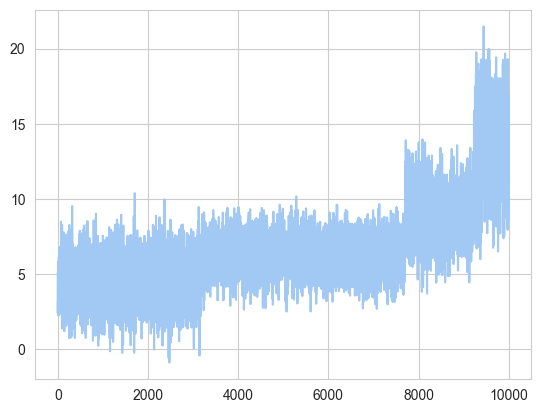

In [ ]:
plt.plot(samples_sorted)

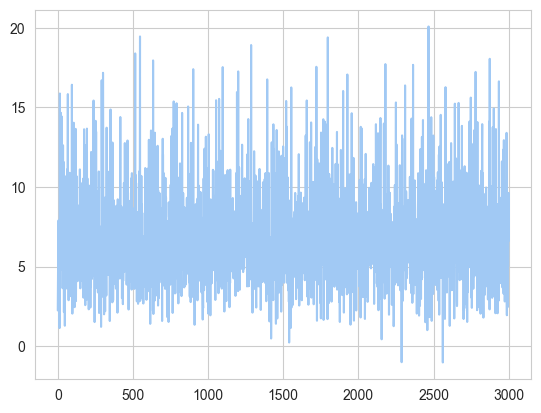

In [ ]:
plt.plot(samples_random)

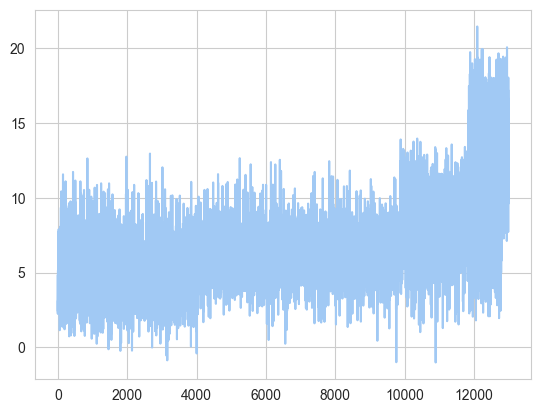

In [ ]:
plt.plot(samples_b)

In [ ]:
initial_samples = sample_zero_sensor_reading(n_samples = int(0.1 * len(samples_b)))

In [ ]:
full_samples = np.concatenate((initial_samples, samples_b))

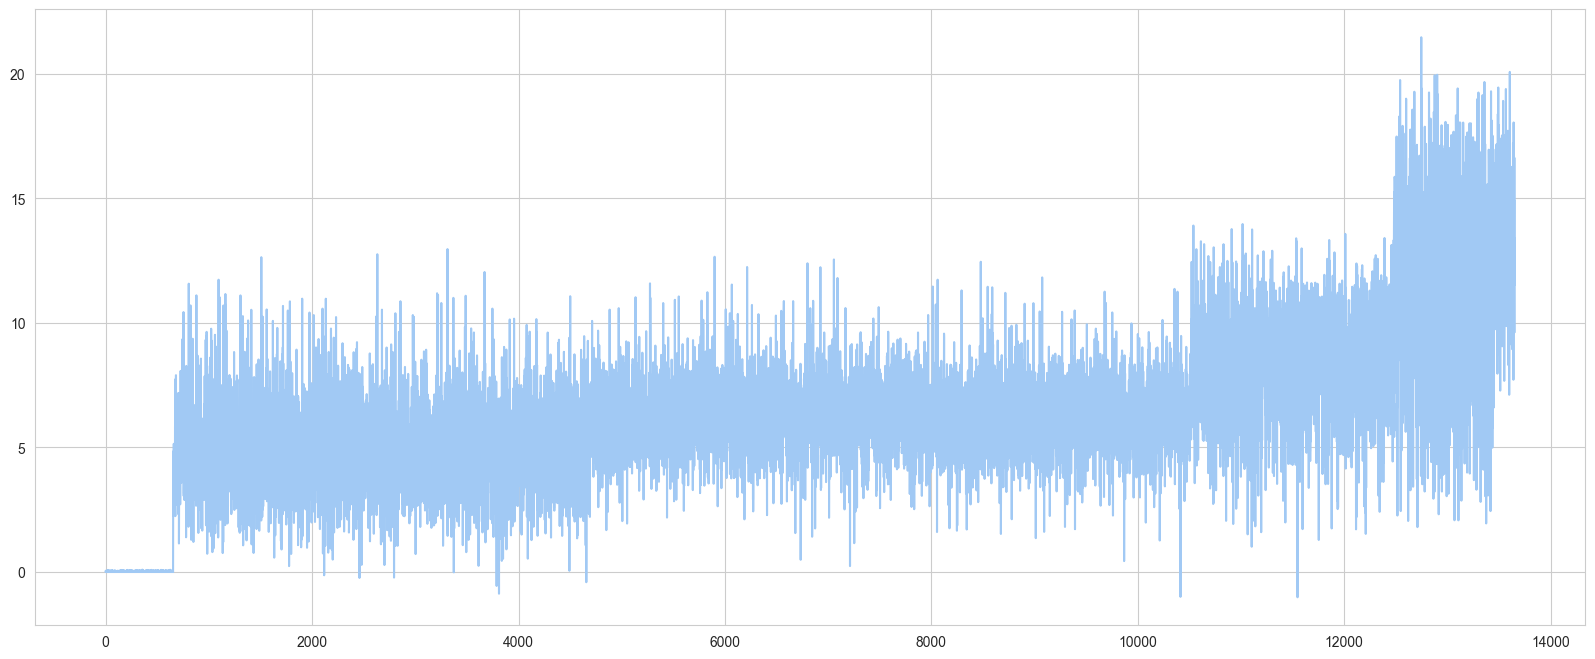

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(full_samples)
plt.show()

In [ ]:
type(full_samples)

numpy.ndarray

In [ ]:
fs = pd.DataFrame(full_samples)

filepath = '../data/full_data.csv'

fs.to_csv(filepath, index=False)

# Monitoring

In [ ]:
gmm[k].means_.flatten()

array([ 4.53688569,  6.27919166,  8.97239358, 13.16553809])

In [ ]:
gmm[k].covariances_.flatten()

array([2.34069746, 1.37166016, 2.58745229, 6.40874242])

## Condition Monitoring & Fault Diagnostics

In [477]:
from scipy.stats import norm
indicator = {99: "faulty sensor", 0: "inaktiv", 1: "low load", 2: "normal load", 3: "high load", 4: "anomaly load"}
means = gmm[k].means_.flatten()
covariances = gmm[k].covariances_.flatten()
condition = []
for sample in full_samples:
    if sample < 0:
        condition.append(99)
    elif sample < 0.5:   
        condition.append(0)
    else:
        likelihoods = [norm.pdf(sample, mean, np.sqrt(variance)) for mean, variance in zip(means, covariances)]

        max_likelihood = max(likelihoods)
        most_likely_distribution = likelihoods.index(max_likelihood) + 1
    condition.append(most_likely_distribution)

In [483]:
from scipy.stats import norm
indicator = {99: "faulty sensor", 0: "inaktiv", 1: "low load", 2: "normal load", 3: "high load", 4: "clogged filter", 5: "anomaly load"}
means = gmm[k].means_.flatten()
covariances = gmm[k].covariances_.flatten()
condition = []
for sample in full_samples:
    if sample < 0:
        condition.append(99)
    elif sample < 0.5:   
        condition.append(0)
    elif ((0 < sample) & (sample <= 4.8)):
        condition.append(1)
    elif ((4.8 < sample) & (sample <= 8)):
        condition.append(2)
    elif ((8 < sample) & (sample <= 11.8)):
        condition.append(3)
    elif ((11.8 < sample) & (sample <= 18)):
        condition.append(4)
    else:
        condition.append(5)

C:\Users\U\AppData\Local\Temp\ipykernel_13960\2559217380.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.unique(condition)


array([0, 1, 2, 3])

In [487]:
from sklearn.linear_model import LinearRegression

def extrapolate_and_suggest_maintenance(last_10_samples, threshold=11.8):
    if len(last_10_samples) < 10:
        raise ValueError("Not enough data points to extrapolate.")
    
    last_10_samples = np.array(last_10_samples[-10:]).reshape(-1, 1)
    time_points = np.array(range(len(last_10_samples) - 10, len(last_10_samples))).reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(time_points, last_10_samples)
    
    next_time_point = np.array([[len(last_10_samples)]])
    extrapolated_value = model.predict(next_time_point)[0][0]
    
    maintenance_suggested = extrapolated_value > threshold
    
    return maintenance_suggested, extrapolated_value

print(len(full_samples))
for i in range(10, len(full_samples)):
    maintenance_suggested, extrapolated_value = extrapolate_and_suggest_maintenance(full_samples[i-10:i])
    if maintenance_suggested:
        print(f"Alarm, mainteannce required at time {i}")


13654
Alarm, mainteannce required at time 10541
Alarm, mainteannce required at time 11027
Alarm, mainteannce required at time 11290
Alarm, mainteannce required at time 11415
Alarm, mainteannce required at time 11416
Alarm, mainteannce required at time 11468
Alarm, mainteannce required at time 11469
Alarm, mainteannce required at time 11589
Alarm, mainteannce required at time 11590
Alarm, mainteannce required at time 11688
Alarm, mainteannce required at time 11722
Alarm, mainteannce required at time 11856
Alarm, mainteannce required at time 11857
Alarm, mainteannce required at time 11858
Alarm, mainteannce required at time 11860
Alarm, mainteannce required at time 12130
Alarm, mainteannce required at time 12394
Alarm, mainteannce required at time 12480
Alarm, mainteannce required at time 12481
Alarm, mainteannce required at time 12482
Alarm, mainteannce required at time 12483
Alarm, mainteannce required at time 12484
Alarm, mainteannce required at time 12485
Alarm, mainteannce required 